# Monte Carlo Tree Search

In [1]:
import numpy as np
from random import uniform

In [2]:
class Node:
    def __init__(self, depth=20, parent=None, name='', B=10, tau=None):
        self.parent = parent
        self.name = name
        self.B = B
        self.tau = depth/5 if tau is None else tau
        if depth > 0:
            self.left = Node(depth=depth-1, parent=self, name=name+"L", B=B, tau=self.tau)
            self.right = Node(depth=depth-1, parent=self, name=name+"R", B=B, tau=self.tau)
            self.leaf = False
        else:
            self.left, self.right = None, None
            self.leaf = True
    
    def __repr__(self):
        return ("Leaf n" if self.leaf else "N") + f"ode {self.name}" if self.name != '' else "Root node"
    
    def select_target(self):
        if self.leaf:
            return self.name
        # Selecting a target by randomly and recursively choosing between children
        self.target = self.left.select_target() if uniform(0, 1) < 0.5 else self.right.select_target()
        return self.target
    
    # Assign values to every leaf from this root based on the distance from the target
    # However, assigning all values in a large tree is inefficient; better to assign value when sampled
    def assign_values(self, target=None):
        if target is None:
            if not hasattr(self, 'target'):
                raise AttributeError("This node cannot implicitly assign values. A target must be specified")
            target = self.target
        if self.leaf:
            self.value = self.B*np.exp(-self.distance(target)/self.tau) + np.random.randn()
        else:
            self.left.assign_values(target=target)
            self.right.assign_values(target=target)
    
    def distance(self, target):
        return (~(np.asarray(list(self.name)) == np.asarray(list(target)))).sum()
    
    # Useful for checking the values of each leaf node but should only be called for small trees
    def list_leaves(self):
        if self.leaf:
            print(f"{self}: {self.value:.04f}")
            return
        self.left.list_leaves()
        self.right.list_leaves()

In [3]:
class MonteCarloTreeSearch:
    def __init__(self, tree, c=1, leaf_values=False):
        self.tree = tree
        self.current_root = tree
        self.initialize_node(tree)
        self.c = c
        self.n = 0
        # If the leaves have values pre-assigned
        self.leaf_values = leaf_values
    
    def search(self, n=50):
        while not self.current_root.leaf:
            self.iteration()
            if self.current_root.n >= n:
                self.current_root = self.better_child(self.current_root)
    
    def iteration(self):
        node = self.current_root
        while True:
            node = self.better_child(node)
            # Stop if a leaf or unvisited node is reached. In the latter case use rollout
            if node.leaf or node.n == 0:
                # Only one rollout per "snowcap" leaf node in this implementation
                value = node.value if node.leaf else self.rollout(node)
                self.backprop(node, value)
                self.n += 1
                break
    
    def better_child(self, node):
        for child in [node.left, node.right]:
            # Initialize child if it has not been been previously visited
            if not hasattr(child, 'value'):
                self.initialize_node(child)
            self.calculate_value(child)
        return max([node.left, node.right], key=lambda x: x.value)
    
    def initialize_node(self, node):
        if node.leaf:
            node.assign_values(self.tree.target)
        else:
            node.total = 0
            node.n = 0
    
    def calculate_value(self, node):
        # If the node is a leaf node, its value is known
        if node.leaf: return
        # Because of division by 0 in the UCB, the initial value is set to infinity
        node.value = np.infty if node.n == 0 else node.total / node.n + self.c * np.sqrt(np.log(self.n) / node.n)
        
    def rollout(self, node):
        if node.leaf:
            if not self.leaf_values and not hasattr(node, 'value'):
                node.assign_values(self.tree.target)
            return node.value
        # Choose left or child with equal probability for the rollout policy
        return self.rollout(node.left if uniform(0, 1) < 0.5 else node.right)
    
    def backprop(self, node, value):
        # Leaf node values do not need to be estimated
        if not node.leaf:
            node.total += value
            node.n += 1
        while node.parent is not None:
            node = node.parent
            node.total += value
            node.n += 1
    
    def target(self):
        node = self.tree
        while not node.leaf:
            # If the search has not converged, the output will be somewhat random
            node = self.better_child(node) 
        return node.name

In [4]:
tree = Node(depth=20)
tree.select_target()
# tree.assign_values()
tree.target

'LLLRRLRRLLRRRLRRLLRL'

In [5]:
mcts = MonteCarloTreeSearch(tree)
mcts.search(n=50)
mcts.target()

'LRLRLLRRLLRLRLRRLRLL'

In [6]:
(~(np.asarray(list(tree.target)) == np.asarray(list(mcts.target())))).sum()

5

# Reinforcement Learning

## Policy Gradient

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from random import choice

In [8]:
class Environment:
    def __init__(self, L=10, left_reward=0, right_reward=20):
        self.states = np.arange(-L-1, L+2)
        self.terminal = [min(self.states), max(self.states)]
        self.rewards = [left_reward, right_reward]
    
    def reset(self):
        self.state = choice(self.states[1:-1])
        return self.state
    
    def step(self, a):
        # Check if environment is initialized
        if not hasattr(self, 'state'):
            raise RuntimeError("Environment.reset must be called before calling Environment.step")
        # Check if the action is valid
        if a not in ['L', 'R']:
            raise ValueError("The action must be either 'L' or 'R'")
        
        state = self.state + (-1 if a == 'L' else 1)
        terminal = state in self.terminal
        reward = -1 if not terminal else (self.rewards[0] if state == min(self.states) else self.rewards[1])
        self.state = state
        # Delete state to avoid undefined behavior for subsequent step method calls
        if terminal: delattr(self, 'state')
        return state, reward, terminal

In [9]:
class Policy:
    def __init__(self, theta=0, beta=0.5):
        self.ACTIONS = ['L', 'R']
        self.theta = theta
        self.beta = beta
    
    def sample_action(self, state):
        lp, _ = self.get_probs(state)
        # With probability lp select action 0 ('L')
        return self.ACTIONS[int(lp < uniform(0, 1))]
    
    def get_probs(self, state):
        p = (1+np.exp(-self.beta*(state-self.theta)))**-1
        # For completeness, returns probs for both actions
        return 1-p, p

In [10]:
def simulate_episode(env, policy, return_full_episode=False):
    states, actions, rewards = list(), list(), list()
    s = env.reset()
    done = False
    while not done:
        states.append(s)
        a = policy.sample_action(s)
        s, r, done = env.step(a)
        actions.append(a)
        rewards.append(r)
    return (states, actions, rewards) if return_full_episode else sum(rewards)

#### Question 1

In [40]:
env = Environment(L=20)
thetas = np.arange(-20, 21)
rewards = {theta: list() for theta in thetas}
n = 10000

for theta in thetas:
    policy = Policy(theta=theta)
    for _ in range(n):
        rewards[theta].append(simulate_episode(env, policy))
rewards = pd.DataFrame(rewards)

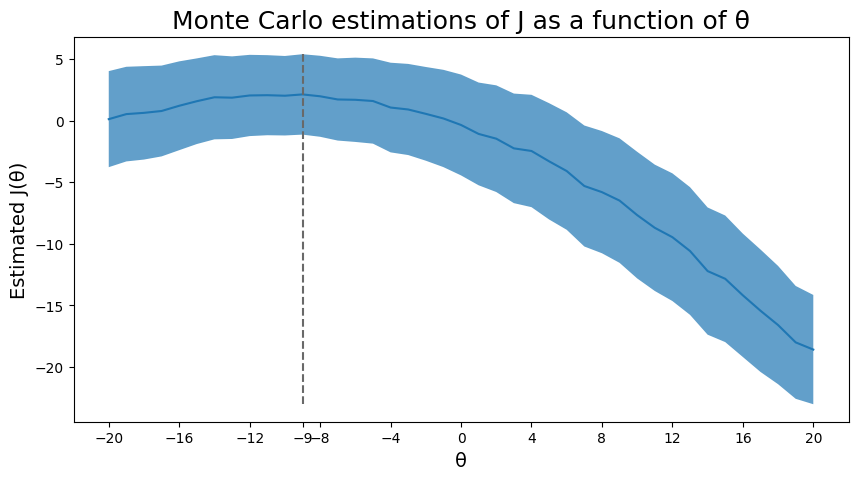

In [58]:
plt.figure(figsize=(10,5))
plt.plot(rewards.columns, rewards.mean())
plt.fill_between(rewards.columns, rewards.mean() + rewards.std()/3, rewards.mean() - rewards.std()/3, alpha=0.7)
plt.vlines(rewards.mean().idxmax(), (rewards.mean() - rewards.std()/3).min(), (rewards.mean() + rewards.std()/3).max(), color='dimgray', linestyles='--')
plt.xlabel("θ", fontsize=14)
plt.xticks(list(range(-20, 21, 4)) + [rewards.mean().idxmax()])
plt.ylabel("Estimated J(θ)", fontsize=14)
plt.title("Monte Carlo estimations of J as a function of θ", fontsize=18)
plt.show()

#### Question 2

In [13]:
theta = 0
h = 1e-1
p1, p2 = Policy(theta=theta + h), Policy(theta=theta)
policy_diff = lambda: simulate_episode(env, p1) - simulate_episode(env, p2)

n = 100000
sum([policy_diff() / h for _ in range(n)]) / n

-0.3241

#### Question 3

In [157]:
def compute_grad(policy, episode):    
    grad, R = 0, 0
    for s, a, r in reversed(list(zip(*episode))):
        R += r
        grad += R * policy.beta * (policy.get_probs(s)[1] - (1 if a == 'R' else 0))
    return grad

In [158]:
# Gradient ascent playground to test if the algorithm works as expected
L = 20
left_reward = 0
right_reward = 20
theta0 = 0
lr = 1e-2
n_episodes = 50000

env = Environment(L=L, left_reward=left_reward, right_reward=right_reward)
policy = Policy(theta=theta0)
for _ in range(n_episodes):
    grad = compute_grad(policy, simulate_episode(env, policy, return_full_episode=True))
    policy.theta += lr * grad
print(policy.theta)

-10.205888790435116


# Advantage Actor-Critic

In [164]:
from collections import defaultdict

def MC_prediction(V, counts, states, rewards):
    R = 0
    for i, (s, r) in enumerate(zip(reversed(states), reversed(rewards))):
        R += r
        # Only consider first visits
        if s not in states[:-i-1]:
            counts[s] += 1
            V[s] += (R-V[s]) / counts[s]

env = Environment(L=20)
policy = Policy()
V = defaultdict(float)
counts = defaultdict(float)
n_episodes = 100

for _ in range(n_episodes):
    states, _, rewards = simulate_episode(env, policy, return_full_episode=True)
    MC_prediction(V, counts, states, rewards)

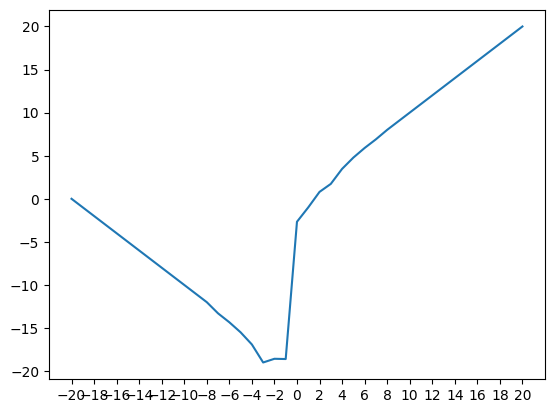

In [165]:
pd.Series(V).sort_index().plot()
plt.xticks(env.states[1:-1:2])
plt.show()

In [166]:
def compute_grad(policy, episode, V):    
    grad, R = 0, 0
    for s, a, r, ns in zip(*episode, episode[0][1:] + [np.infty]):
        # print(s,ns, (V[ns] - V[s] + r))
        grad += (V[ns] - V[s] + r) * policy.beta * (policy.get_probs(s)[1] - (1 if a == 'R' else 0))
    return grad

In [167]:
lr = 0.5
n_episodes = 5000

for _ in range(n_episodes):
    episode = simulate_episode(env, policy, return_full_episode=True)
    grad = compute_grad(policy, episode, V)
    MC_prediction(V, counts, episode[0], episode[2])
    policy.theta += lr * grad
print(policy.theta)

-9.4135449876523


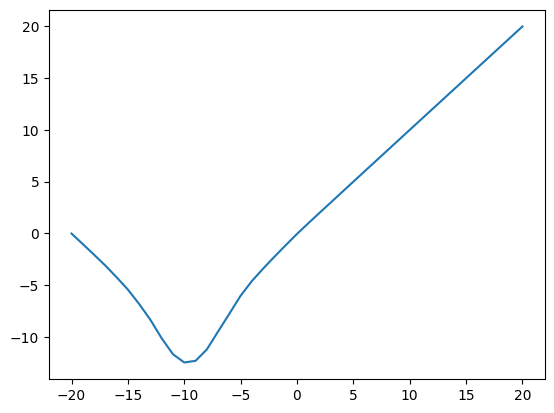

In [168]:
pd.Series(V).sort_index().plot()
plt.show()